In [1]:
import numpy as np
import pandas as pd
import os, subprocess, shutil
import matplotlib.pyplot as plt

REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

caseName   = "unsteadyDOC"
solverFoam = "nutrientCycle"
names = ["XAR", "XN", "XDN", "XARp", "XNp", "XDNp", 
   "EPS", "XI", "BAP", "POCr", "DOC", "NH4", "NO3", "O2", "U", "katt", "n"]
probeVars  = " ".join(names)

## Check that solver is compiled
if not(solverFoam in subprocess.run(["which",f"{solverFoam}"],capture_output=True).stdout.decode('utf-8').strip()):
    print("######### SOLVER NOT FOUND ############")

In [2]:
## Bring template for probes
subprocess.run(f"cp {REPO_PATH}/misc/probes_inOut.tpl {caseName}/system/probes".split())

## Replace placeholders in template
subprocess.run(["sed", "-i", f"s/<<LIST_OF_VARIABLES_TO_MEASURE>>/({probeVars})/g", f"{caseName}/system/probes"])

column_lenght = 0.62
subprocess.run(["sed", "-i", f"s/<<OUT_LOCATION>>/(0 0 {column_lenght})/g", f"{caseName}/system/probes"])

## Clean previous runs
subprocess.run([f"foamListTimes", "-rm"], cwd=f"./{caseName}")

## Clean postprocessing
postProc_path = f"{caseName}/postProcessing"
if os.path.exists(postProc_path): shutil.rmtree(postProc_path)

Using #calcEntry at line 19 in file "/home/edsaac/Repos/ReactiveBiomass/experiments/Rosenzweig_2011/unsteadyDOC/system/controlDict"
Using #codeStream with "/home/edsaac/Repos/ReactiveBiomass/experiments/Rosenzweig_2011/unsteadyDOC/dynamicCode/platforms/linux64GccDPInt32Opt/lib/libcodeStream_426e784e466f92537c532d75c85b98e62525deb9.so"


In [3]:
## Run case
subprocess.run(["nutrientCycle"], cwd=f"./{caseName}", stdout=subprocess.DEVNULL)

#0  Foam::error::printStack(Foam::Ostream&) at ??:?
#1  Foam::sigFpe::sigHandler(int) at ??:?
#2  ? in "/lib/x86_64-linux-gnu/libc.so.6"
#3  ? in "/lib/x86_64-linux-gnu/libm.so.6"
#4  powf64 in "/lib/x86_64-linux-gnu/libm.so.6"
#5  Foam::pow(Foam::Field<double>&, Foam::UList<double> const&, double const&) at ??:?
#6  Foam::tmp<Foam::GeometricField<double, Foam::fvPatchField, Foam::volMesh> > Foam::pow<Foam::fvPatchField, Foam::volMesh>(Foam::tmp<Foam::GeometricField<double, Foam::fvPatchField, Foam::volMesh> > const&, Foam::dimensioned<double> const&) at ??:?
#7  Foam::cloggingModels::powerLaw::calcPerm() at ??:?
#8  ? in "/home/edsaac/OpenFOAM/edsaac-7/platforms/linux64GccDPInt32Opt/bin/nutrientCycle"
#9  __libc_start_main in "/lib/x86_64-linux-gnu/libc.so.6"
#10  ? in "/home/edsaac/OpenFOAM/edsaac-7/platforms/linux64GccDPInt32Opt/bin/nutrientCycle"


CompletedProcess(args=['nutrientCycle'], returncode=-8)

In [16]:
postProc_clean = f"{caseName}/postProcessingClean"
if os.path.exists(postProc_clean): shutil.rmtree(postProc_clean)
shutil.copytree(postProc_path, postProc_clean)

'unsteadyDOC/postProcessingClean'

In [17]:
location_probes = f"{postProc_clean}/probes/0.000"

for file in os.listdir(location_probes):
    subprocess.run(["sed", "-i", r"s/\s\s\+/\t/g", file], cwd=location_probes)
    subprocess.run(["sed", "-i", r"s/^\t//g", file], cwd=location_probes)
    subprocess.run(["sed", "-i", r"/^#/d", file], cwd=location_probes)

In [18]:
probes = os.listdir(location_probes)
probes.sort(reverse=True)

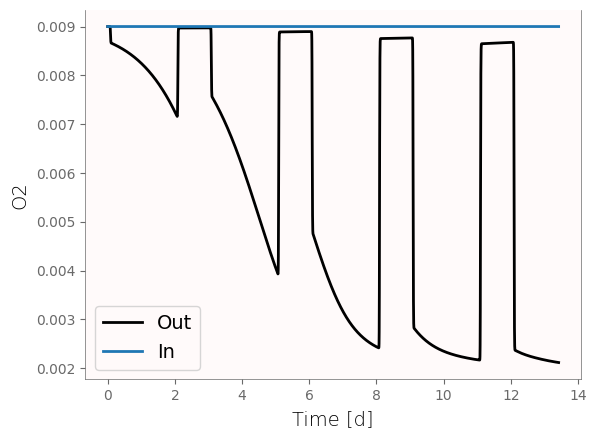

In [31]:
probe = "O2"
results = pd.read_csv(os.path.join(location_probes,probe),sep="\t",names=["Time (s)", "Out", "In"], index_col="Time (s)")

fig,ax = plt.subplots()
ax.plot(results.index/86400, results['Out'], label = 'Out')
ax.plot(results.index/86400, results['In'], label = 'In')
ax.legend()
ax.set_xlabel("Time [d]")
ax.set_ylabel(probe)
plt.show()

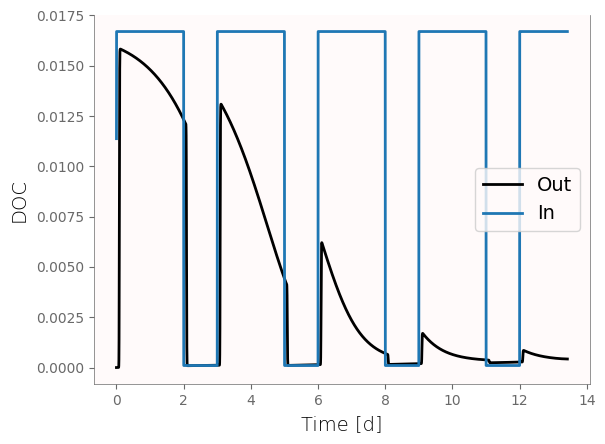

In [32]:
probe = "DOC"
results = pd.read_csv(os.path.join(location_probes,probe),sep="\t",names=["Time (s)", "Out", "In"], index_col="Time (s)")

fig,ax = plt.subplots()
ax.plot(results.index/86400, results['Out'], label = 'Out')
ax.plot(results.index/86400, results['In'], label = 'In')
ax.legend()
ax.set_xlabel("Time [d]")
ax.set_ylabel(probe)
plt.show()

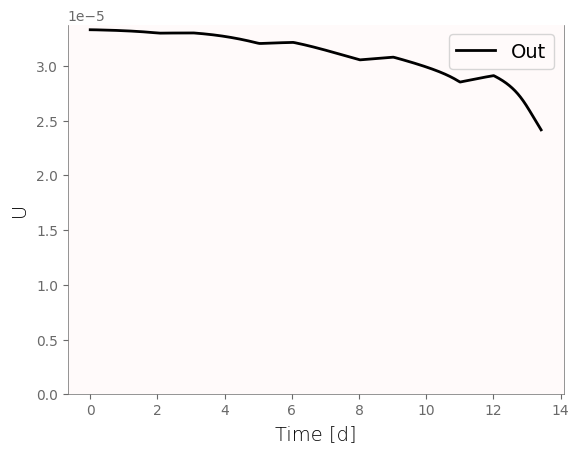

In [34]:
probe = "U"
results = pd.read_csv(os.path.join(location_probes,probe), sep="\t", names=["Time (s)", "Out", "In"], index_col="Time (s)")

results.head()

results['Out'] = [float(i.split(" ")[-1].replace(")","")) for i in results["Out"]]
results['In'] = [float(i.split(" ")[-1].replace(")","")) for i in results["In"]]

fig,ax = plt.subplots()
ax.plot(results.index/86400, np.abs(results['Out']), label = 'Out')
ax.legend()
ax.set_xlabel("Time [d]")
ax.set_ylabel(probe)
ax.set_ylim(ymin=0)
plt.show()

In [35]:
integralOverTime = pd.read_csv(f"{caseName}/IntegrationOverTime.csv")

In [44]:
integralOverTime = integralOverTime[[i for i in integralOverTime.columns if 'avg' in i]]

In [51]:
integralOverTime.index

RangeIndex(start=0, stop=322, step=1)

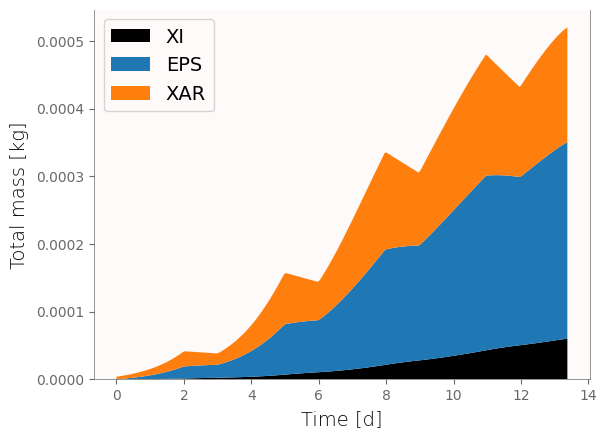

In [59]:
fig,ax = plt.subplots()
ax.stackplot(integralOverTime.index/24, integralOverTime['avg(XI)'],integralOverTime['avg(EPS)'],integralOverTime['avg(XAR)'],labels=["XI","EPS","XAR"])
ax.legend(loc="upper left")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Total mass [kg]")
plt.show()